In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
%matplotlib notebook

# Maximum Likelihood Estimation

#### Version 0.1

-----

By AA Miller (Northwestern/CIERA)

15 Sep 2022

This notebook explores some basics for numerical maximum likelihood estimation.

## Problem 0) Helper Functions

We will need to make lots of plots of data and models throughout this notebook.

**Problem 0a**

Write a function `data_plot()` that creates and returns `matplotlib` figure and axes instances using [`plt.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html).

The function should label the abcissa `x` and the ordinate `y`, and take optional arguments `x_obs`, `y_obs`, `y_obs_unc` that are plotted when provided by the user. 

In [3]:
def data_plot(x_obs=[], y_obs=[], y_obs_unc=[]):
    
    fig, ax = plt.subplots()
    
    if len(x_obs) > 0 and len(y_obs) > 0:
        if len(y_obs_unc) > 0:
            ax.errorbar(x_obs, y_obs, y_obs_unc, 
                        fmt='o', mec='RebeccaPurple', mfc='white', 
                        ecolor='RebeccaPurple')
        else:
            ax.errorbar(x_obs, y_obs, 
                        fmt='o', mec='RebeccaPurple', mfc='white')
    
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.tick_params('both', labelsize=13)
    return fig, ax

**Problem 0b**

Using `np.random` simulate 15 observations that are drawn from a linear relation defined by $f(x) = 3.14\,x + 6.626$. The observations should be collected over the range [0,10]. 

Assume that the observations are noisy, and the scatter is described by a Gaussian with variance = 9. 

In [4]:
n_obs = 15
rng = np.random.default_rng(seed=2009)

x_obs = rng.uniform(0, 10, n_obs)
y_obs = rng.normal(3.14*x_obs + 6.626, 3)
y_obs_unc = np.ones_like(y_obs)*3

**Problem 0c**

Confirm your results from the previous two problems by using `data_plot()` to display the observations generated in **0b**.

<IPython.core.display.Javascript object>


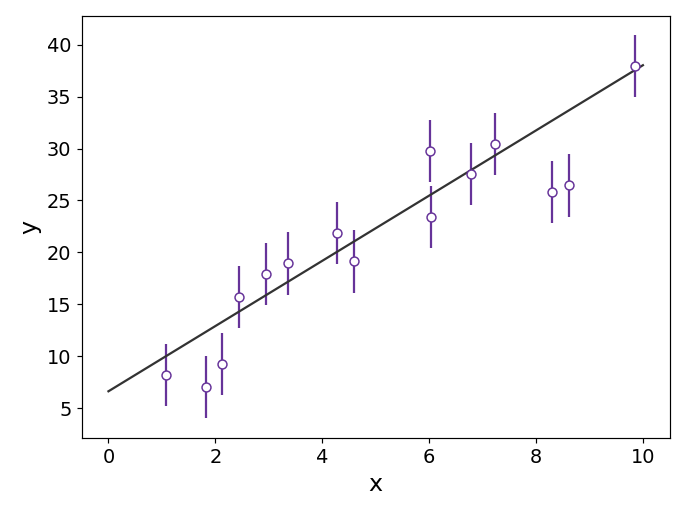

In [5]:
fig, ax = data_plot(x_obs, y_obs, y_obs_unc)
fig.tight_layout()

**Problem 0d**

Confirm you can add to your figure instance by over-plotting the true relation used to generate the data.

Did you get the Gaussian scatter correct? 

*Hint* – for Gaussian noise $\sim$68% of the observations should be within 1-$\sigma$ of the true relation.

In [6]:
ax.plot([0,10], [6.626, 6.626 + 31.4], '0.2')
fig.show()

*write your answer here*

10/15 observations are within 1 sigma, so the scatter is correct in this case. 

## Problem 1) The likelihood

As we saw in Lecture II, the likelihood is just the product of the probability of all the individual observations within a data set:

$$\mathcal{L} \equiv \prod p(x_i|\mathcal{M}(\theta))$$

Our aim is to identify model parameters $\theta$ that *maximize* the likelihood. 

**Probelm 1a**

Write a function `model` with two input parameters, `theta` and `x`, where `theta` is a tuple with values $\theta_0$ and $\theta_1$, and the function returns $\theta_0 + \theta_1 x$.

*Hint* – this is far more formal than necessary, but it will simplify other problems later in the notebook. 

In [7]:
def model(theta, x):
    '''
    Return dependent variable values for f(x) = theta_0 + theta_1 x
    
    Parameters
    ----------
    theta : tuple (size=2)
        theta[0] is the intercept and theta[1] is the slope of the line
    
    x : array-like
        values of the independent variable where f(x) should be evaluated
    '''
    
    b, m = theta
    return m*x + b

**Problem 1b**

Write a function `prob` that calculates and returns the probability of observations `x` assuming that $p(x)$ follows a normal distribution with mean `mu` and standard deviation `sigma`. 

In [8]:
def prob(x, mu, sigma):
    p = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2/(2*sigma**2))
    return p

**Problem 1c**

Calculate the likelihood for the observations that were simulated in **0b**. Use the model parameters that generated the data. 

*Hint* – think carefully about your variable names. 

In [9]:
lkhd = np.prod(prob(y_obs, model((6.626, 3.14), x_obs), y_obs_unc))

print(f'The likelihood for this data set is {lkhd}')

The likelihood for this data set is 3.342203541177402e-20


That is a very small number! 

**Problem 1d**

Using the same model parameters as before, generate data sets of 100, 200, and 300 observations, and calculate the likelihood for each.

*Hint* – do not use the same variable names (e.g., `x_obs`, `y_obs`, etc) that we used before; we do not want to over-write those variables.

In [10]:
for n_obs in [100, 200, 300]:

    rng = np.random.default_rng(seed=2009)

    x_sim = rng.uniform(0, 10, n_obs)
    y_sim = rng.normal(3.14*x_sim + 6.626, 3)
    y_sim_unc = np.ones_like(x_sim)*3

    lkhd = np.prod(prob(y_sim, model((6.626, 3.14), x_sim), y_sim_unc))

    print(f'The likelihood for {n_obs} observations is {lkhd}')

The likelihood for 100 observations is 7.769122769272192e-114
The likelihood for 200 observations is 5.154240581981471e-218
The likelihood for 300 observations is 0.0


300 observations is a small number! Gaia has observed more than 1 billion stars, and yet, with only 300 observations in an outrageously simple dataset, the likelihood is so small it is equivalent to 0 at machine precision. 


This is why it is always a good idea to work with the log of the likelihood, not only does this turn a product into a sum, more importantly, the calculations become far more stable on your machine. 

**Problem 1e**

Write a function `lnl` that calculates the log likelihood for some observations, their uncertainties, and the model to which the observations are being compared. Assume that the likelihood is Gaussian.

*Hint* – the `model` function that was created earlier should be inside the `lnl` function, this means that `theta` should be the first arguement for the `lnl` function.

*Note* – likelihoods are calculated for comparison purposes, their absolute value does not have much meaning, so you can ignore constant terms for this function. 

In [11]:
def lnl(theta, y_obs, y_obs_unc, x_obs):
    y_model = model(theta, x_obs)
    return -1/2*np.sum((y_obs-y_model)**2/y_obs_unc**2)

**Problem 1f**

Using the same model parameters as before, generate data sets of 100, 200, and 300 observations, and calculate the *log likelihood* for each.

In [12]:
for n_obs in [100, 200, 300]:

    rng = np.random.default_rng(seed=2009)

    x_sim = rng.uniform(0, 10, n_obs)
    y_sim = rng.normal(3.14*x_sim + 6.626, 3)
    y_sim_unc = np.ones_like(x_sim)*3

    lnlike = lnl((6.626, 3.14), y_sim, y_sim_unc, x_sim)

    print(f'The ln likelihood for {n_obs} observations is {lnlike}')

The ln likelihood for 100 observations is -58.68946115574464
The ln likelihood for 200 observations is -96.81356610831219
The ln likelihood for 300 observations is -148.61949734946114


## Problem 2) Maximizing the Likelihood

It is all well and good to calculate the likelihood, but what we truly want is to maximize the likelihood. 

Most algorithms are designed to minimize, rather than optimize, a function. Fortunately, minimizing the negative log likelihood is the exact same as maximizing the log likelihood.

**Problem 2a**

Write a function `nll` to calculate the negative log likelihood. 

*Hint* – this is really simple, don't overthink it.

In [13]:
def nll(theta, y_obs, y_obs_unc, x_obs):
    return -1*lnl(theta, y_obs, y_obs_unc, x_obs)

**Problem 2b**

Using `minimize` from `scipy.optimize` determine the maximum likelihood estimation for the intercept and slope of the line that was used to generate the synthetic observations. 

*Hint* – for arguments `minimize` needs (1) a function, (2) an initial guess for the model parameters, which is why we've been using a tuple `theta`, and (3) a tuple containing the remaining arguments for the function to be minimized (i.e., the data/observations).

In [ ]:
res = minimize(nll, (0,0), (y_obs, y_obs_unc, x_obs))

print(f'b = {res.x[0]:.4f} and m = {res.x[1]:.4f} for the MLE')

**Problem 2c**

Overplot the line determined by the MLE on top of the synthetic data. 

How does the line compare to the true line used to generate the data?

<IPython.core.display.Javascript object>


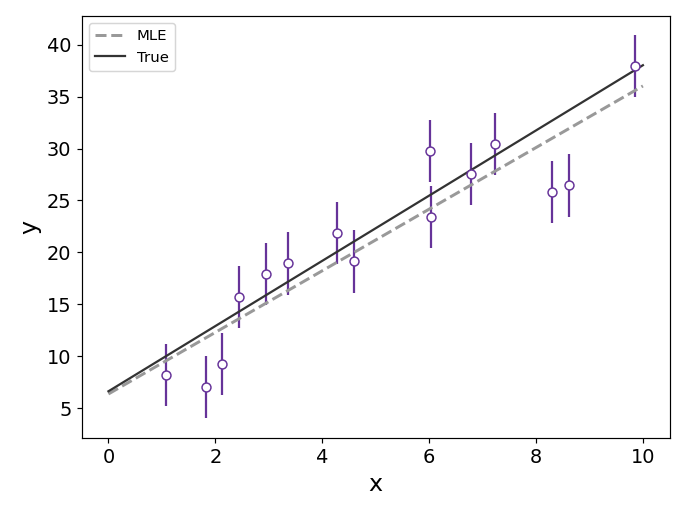

In [20]:
fig, ax = data_plot(x_obs, y_obs, y_obs_unc)
ax.plot([0, 10], model(res.x, np.array([0,10])), 
        '--', color='0.6', label='MLE', lw=2)
ax.plot([0,10], [6.626, 6.626 + 31.4], '0.2', label='True')
ax.legend()
fig.tight_layout()

## Problem 3) Point estimates are nice, but...

In lecture we did not cover how to estimate uncertainties on the model parameters. Using some analytical approximations to the shape of the likelihood it is possible to estimate these values. Using something like `curve_fit` in `scipy` this is where the uncertainties come from.

These methods require that the data do not violate any of the underlying assumptions. For this reason, I prefer to use the bootstrap method to estimate uncertainties on the MLE model parameters. 

Briefly, "new" data sets can be simulated via a bootstrap (randomly choosing a new data set from the observations with replacement) and then finding the MLE parameters again. This can be repeated many times to place confidence limits on the MLE estimates. 

**Problem 3a**

Using [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) select a bootstrap sample from the observations and estimate the MLE model parameters. 

*Hint* – choose a random index so that the input x, y, and y_unc samples are all the same.

In [31]:
boot_idx = np.random.choice(range(len(x_obs)), len(x_obs), replace=True)

res = minimize(nll, (0,0), (y_obs[boot_idx], y_obs_unc[boot_idx], x_obs[boot_idx]))

print(f'b = {res.x[0]:.4f} and m = {res.x[1]:.4f} for the MLE')

b = 6.4976 and m = 2.8767 for the MLE


**Problem 3b**

Create 100 bootstrap samples of the simulated observations and measure the MLE intercept and slope for each. 

Store the results in arrays called `b_boot` and `m_boot`.

In [58]:
n_boot = 100
b_boot = np.zeros(n_boot)
m_boot = np.zeros_like(b_boot)

for idx in range(n_boot):
    boot_idx = np.random.choice(range(len(x_obs)), len(x_obs), replace=True)
    res = minimize(nll, (0,0), (y_obs[boot_idx], y_obs_unc[boot_idx], x_obs[boot_idx]))
    b_boot[idx] = res.x[0]
    m_boot[idx] = res.x[1]

**Problem 3c**

The 68% confidence interval on $b$ (or $m$) is just the central 68% of the bootstrap measuerd distribution for the parameter.

Use `np.percentile()` to determine the 68% C.I. on $b$ and $m$. Do these estimates bracket the true values used to generate the data? 

In [60]:
print('The 68% C.I. on b is {:.4f} to {:.4f}'.format(*np.percentile(b_boot, (16,84))))

print('The 68% C.I. on m is {:.4f} to {:.4f}'.format(*np.percentile(m_boot, (16,84))))


The 68% C.I. on b is 4.2924 to 8.1997
The 68% C.I. on m is 2.5753 to 3.3658


*write your answer here*

The bootstrap estimated C.I. for both parameters does surround the true answers. 

**Problem 3d**

What about correlations between the model parameters? 

Plot the 2d histogram of `m_boot` and `b_boot` to see if the estimates are correlated. 

<IPython.core.display.Javascript object>


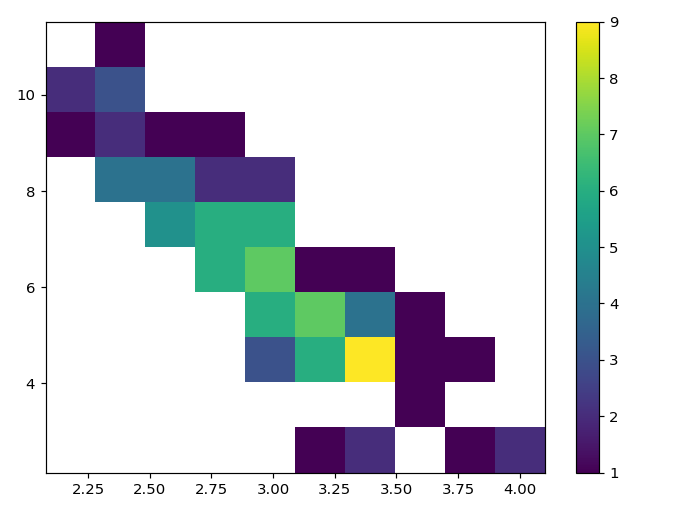

In [62]:
fig, ax = plt.subplots()

cax = ax.hist2d(m_boot, b_boot, cmin=1)
fig.colorbar(cax[3])
fig.tight_layout()

## Problem 4) Model Selection

During lecture we saw two potential methods for selecting between different models. The first was using the $\chi^2_\mathrm{dof}$ and the second was AIC. We will briefly examine each below. 

**Problem 4a** 

Plot the simulated data in the cell below. 

<IPython.core.display.Javascript object>


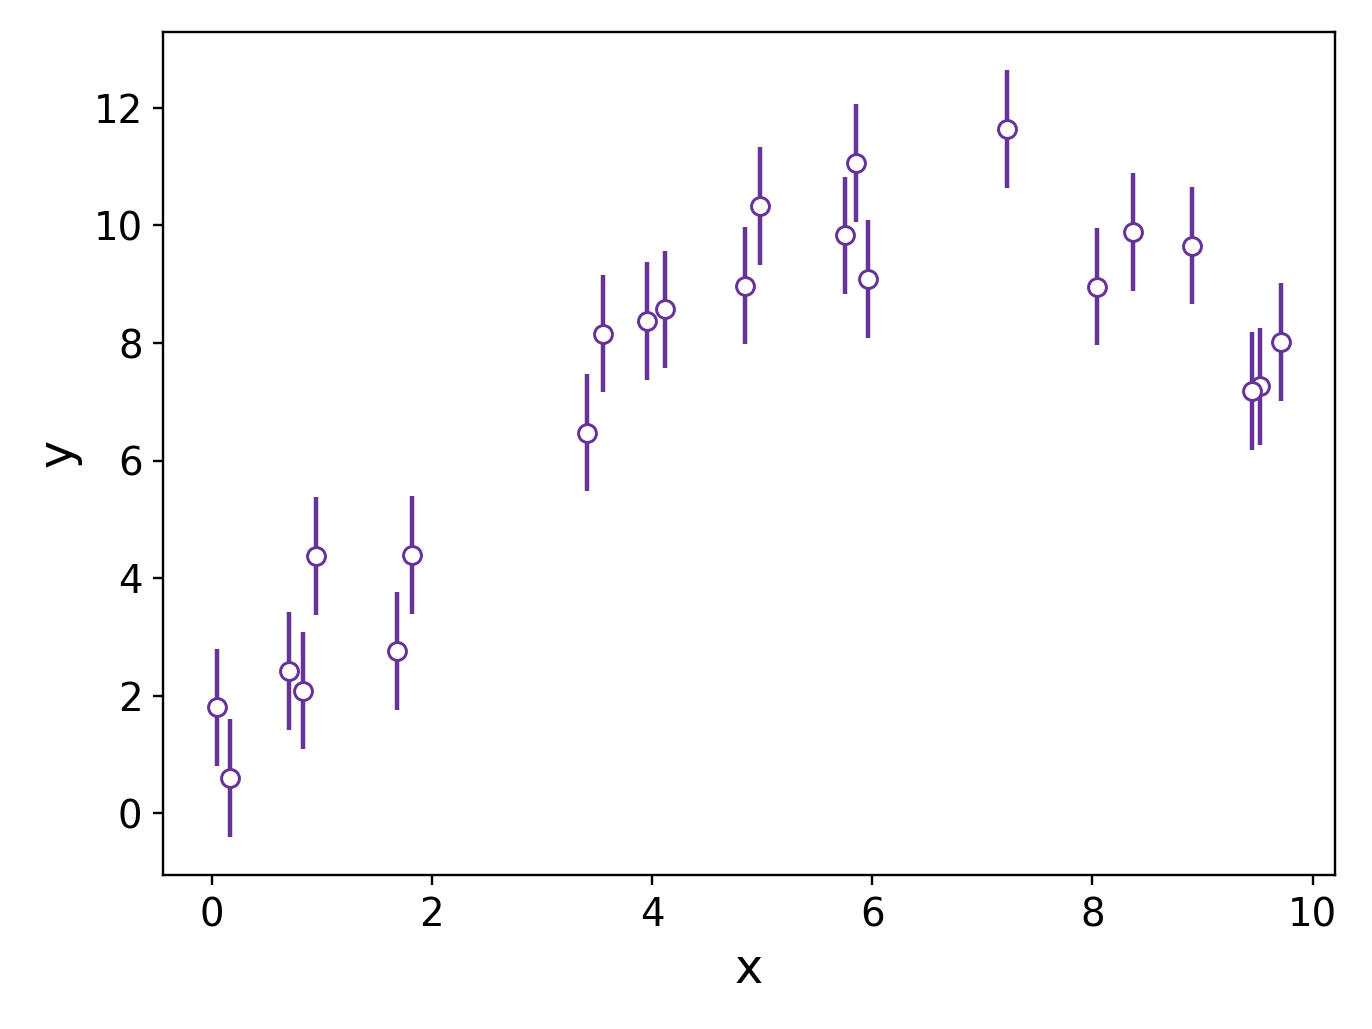

In [88]:
n_obs = 23
rng = np.random.default_rng(seed=1851)
x_obs = rng.uniform(0, 10, n_obs)
y_obs = rng.normal(7.89*np.sin(2*np.pi*x_obs/23) + 0.4*x_obs, 1)
y_obs_unc = np.ones_like(y_obs)*1

fig, ax = data_plot(x_obs, y_obs, y_obs_unc)
fig.tight_layout()

**Problem 4b**

Modify the function `model` from **1a** to accept a tuple of any length and return a polynomial of degree `len(theta)`-1. (This will allow us to compare polynomials of different degree in these problems)

In [89]:
def model(theta, x):
    '''
    Return dependent variable values for polynomial
    
    Parameters
    ----------
    theta : tuple
        coefficients for a polynomial of degree len(theta)-1
    
    x : array-like
        values of the independent variable where f(x) should be evaluated
    '''
    
    f_x = 0
    for c_num, coeff in enumerate(theta):
        f_x += coeff*x**c_num
    
    return f_x

**Problem 4c**

Write a function `chi2dof` to calculate the $\chi^2_\mathrm{dof}$ for a polynomial model. The inputs should be `theta`, as well as the observations and their uncertainties. 

*Hint* – the solution will be dependent upon functions created in the previous problems. 

In [90]:
def chi2dof(theta, y_obs, y_obs_unc, x_obs): 
    
    res = minimize(nll, tuple(np.zeros_like(theta)), (y_obs, y_obs_unc, x_obs))

    dof = len(x_obs) - len(theta)
    
    chi2 = np.sum((y_obs - model(res.x, x_obs))**2/y_obs_unc**2)
    
    return chi2/dof

**Problem 4d**

Fit a first, second, and fifth order polynomial to the observations. 

Which model is "best" based on the $\chi^2_\mathrm{dof}$?

Bonus points - overplot the MLE models on top of the data (you may need to modify `chi2dof` in order to do this easily.

<IPython.core.display.Javascript object>


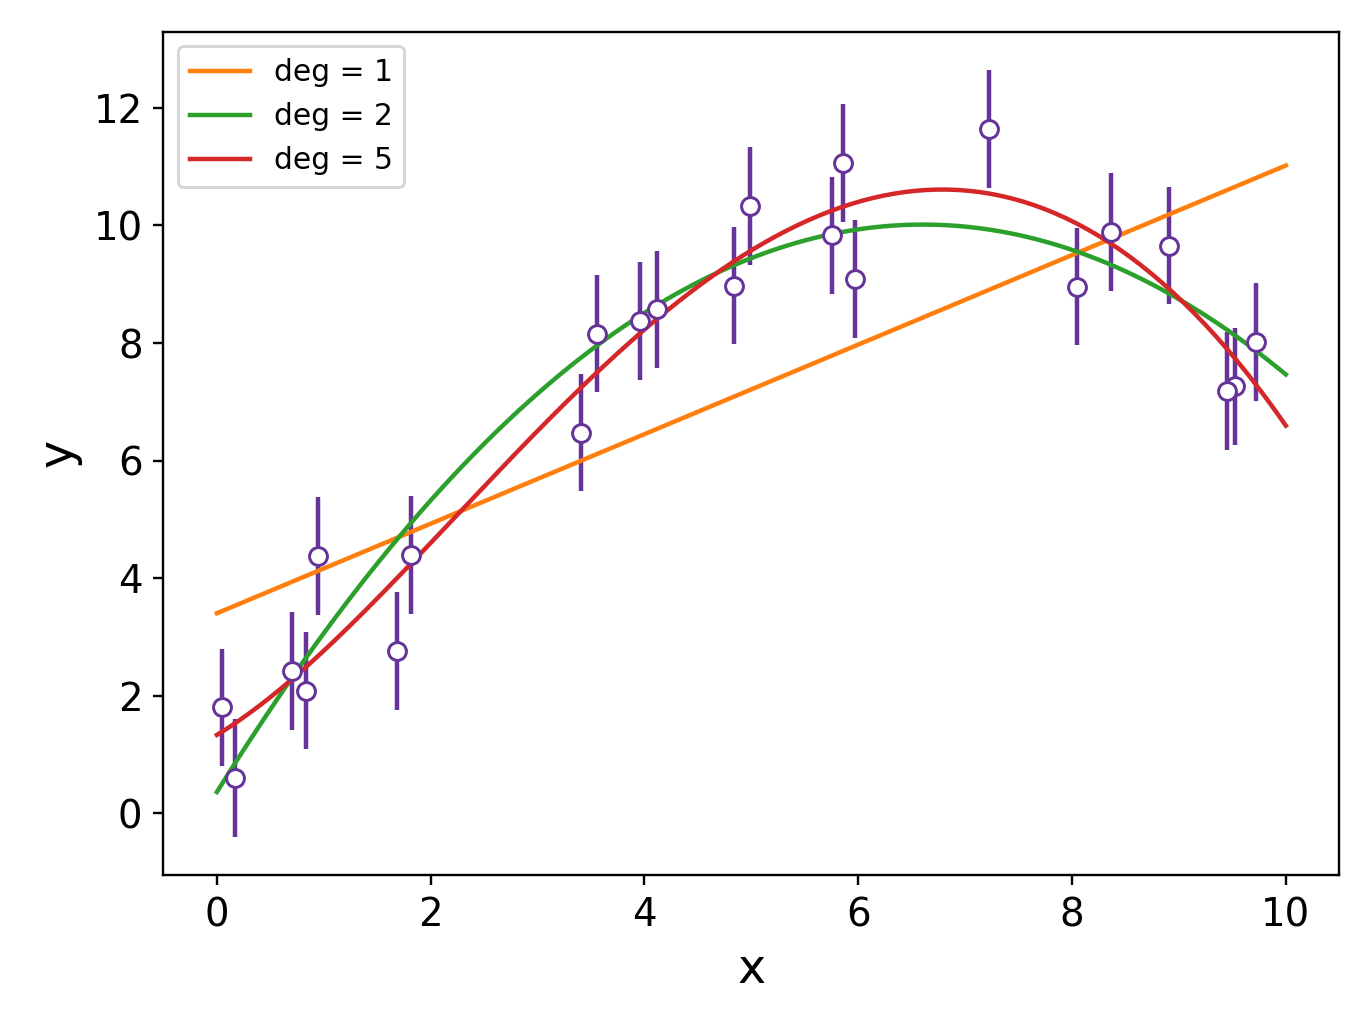

The chi2 for 1th degree polynomial is: 4.850142364808487
The chi2 for 2th degree polynomial is: 0.945973997805529
The chi2 for 5th degree polynomial is: 0.8338494059577853


In [91]:
# modification to chi2dof to add plots to results
def chi2dof(theta, y_obs, y_obs_unc, x_obs): 
    
    res = minimize(nll, tuple(np.zeros_like(theta)), (y_obs, y_obs_unc, x_obs))

    dof = len(x_obs) - len(theta)
    
    chi2 = np.sum((y_obs - model(res.x, x_obs))**2/y_obs_unc**2)
    
    return chi2/dof, res.x

fig, ax = data_plot(x_obs, y_obs, y_obs_unc)
for order in [1, 2, 5]:
    c2, th = chi2dof(tuple(np.zeros(order+1)), y_obs, y_obs_unc, x_obs)
    print('The chi2 for {}th degree polynomial is: {}'.format(order, c2))
    
    xgrid = np.linspace(0, 10, 200)
    ax.plot(xgrid, model(th, xgrid), label=f'deg = {order}')

ax.legend()
fig.tight_layout()

*write your response here*

For this particular data set the 2nd degree polynomial provides the best match to the observations.

## Problem 5) Numerical stability

Polynomials are often used for examples on numerical methods, but nature often provides more complex relations (exponentials, periodicity, power-laws, etc) between the quantities that we can measure. We will examine how that affects MLE.

**Problem 5a**

Execute the cell below to simulate an exponentially declining signal that has a small "bump" at $x = 5$:

$$f(x) = A \exp(-x) - B\;(x - C)^2 \exp(-(x - C)^2)$$

where for this problem $A = 8$, $B = 15$ and $C = 5$. 

*Note* – there is no specific physical system that inspires this data, but you can find examples that look somewhat like this (e.g. emission line in spectra or resonance line in high-energy particle detectors). 

<IPython.core.display.Javascript object>


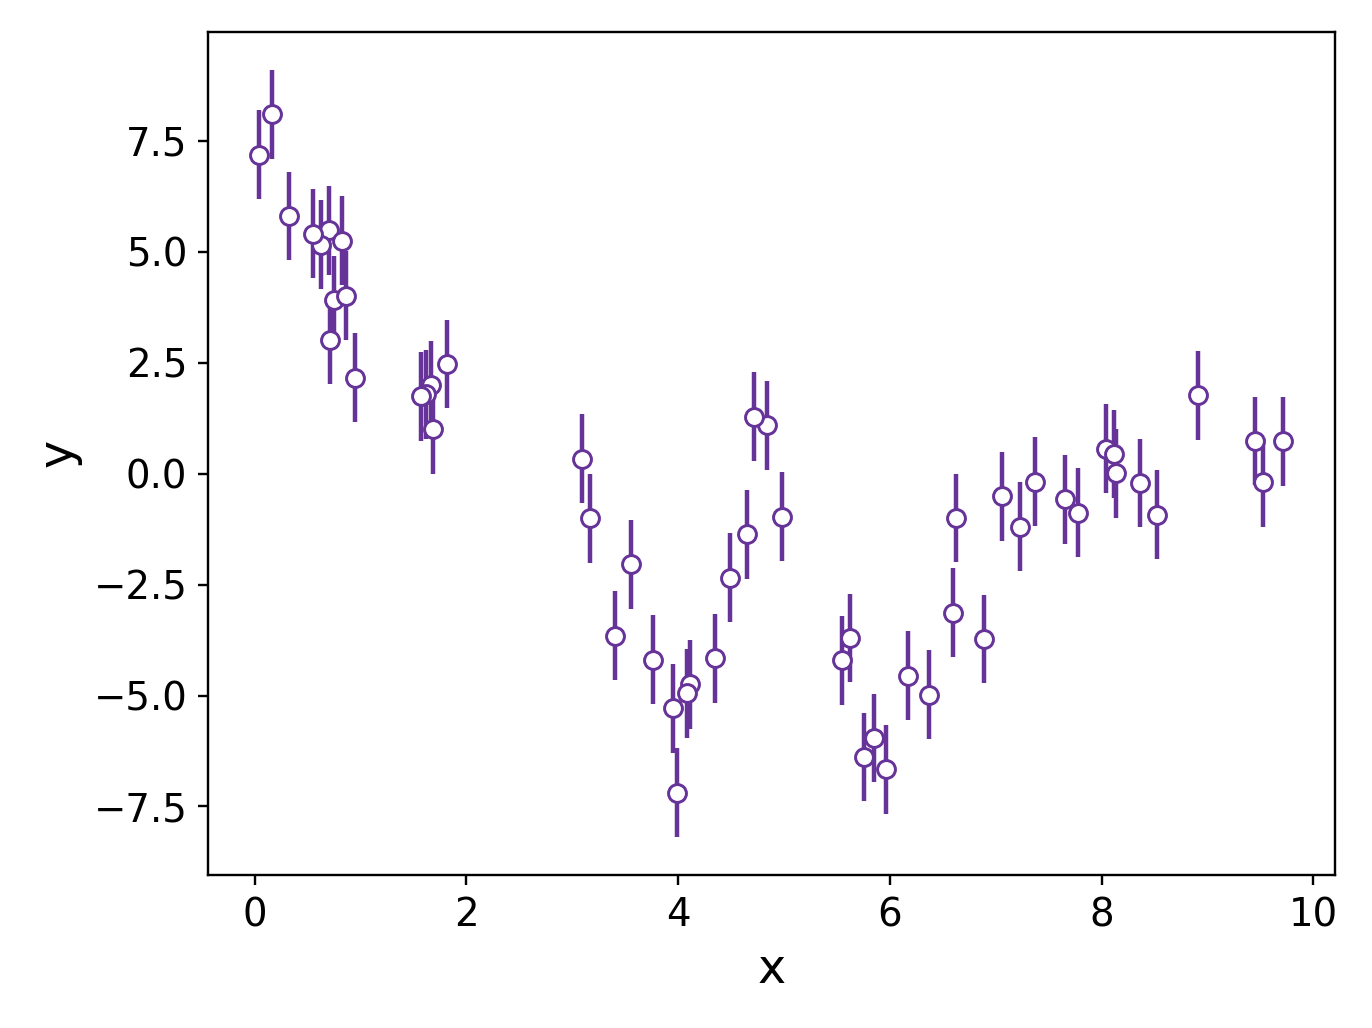

In [148]:
n_obs = 55
rng = np.random.default_rng(seed=1851)
x_obs = rng.uniform(0, 10, n_obs)
y_obs = rng.normal(8*np.exp(-x_obs) - 15*(x_obs-5)**2*np.exp(-(x_obs-5)**2), 1)
y_obs_unc = np.ones_like(y_obs)*1

fig, ax = data_plot(x_obs, y_obs, y_obs_unc)
# ax.set_yscale('log')
fig.tight_layout()

**Problem 5b**

Modify the function `model` to fit the declining exponential function $f(x)$ given in **5a**.

In [149]:
def model(theta, x):
    '''
    Return dependent variable values for polynomial
    
    Parameters
    ----------
    theta : tuple (size = 3)
        A, B, C values for the exponential function A np.exp(-x) - B*(x - C)**2 * np.exp(-(x - C)**2)
    
    x : array-like
        values of the independent variable where f(x) should be evaluated
    '''
    
    f_x = theta[0]*np.exp(-x) - theta[1]*(x_obs-theta[2])**2*np.exp(-(x_obs-theta[2])**2)
        
    
    return f_x

**Problem 5c**

Find the maximum likelihood solution given the observations `y_obs` and `y_obs_unc`. Use an intial guess in your call to `nll` of (1, 1, 1). 

Are your results close to the correct answer?

In [150]:
res = minimize(nll, (1,1,1), (y_obs, y_obs_unc, x_obs))

print('A = {:.4f}, B = {:.4f}, C = {:.4f}'.format(*res.x))

A = 9.4089, B = 9.5815, C = 3.0782


*write your answer here*

These results are somewhat close to the values that generated the data. 

**Problem 5d**

Find the maximum likelihood solution given the observations `y_obs` and `y_obs_unc`. Use an intial guess in your call to `nll` of (20, 20, 20). 

Are your results close to the correct answer?

In [151]:
res = minimize(nll, (20,20,20), (y_obs, y_obs_unc, x_obs))

print('A = {:.4f}, B = {:.4f}, C = {:.4f}'.format(*res.x))

A = 8.4746, B = 20.0000, C = 20.0000


*write your answer here*

These answers are no where close to the model parameters that were used to generate the data!

(If you plot the model with the above parameters you will find that the model does a really poor job of recreating the observations)

Here we have identified one of the problems with MLE (though to be fair, there are similar issues if you are conducting a Bayesian analysis): there is no guarantee that the minimization algorithm that is being used will identify a global minimum. The results that the algorithm obtains can be highly dependent upon the starting position for the minimizer or even the method used to perform the minimization.

**Problem 5e**

Consult the docs for `minimize` and adjust parameters relative to the defaults, but the same starting point as **5d** (20,20,20), to arrive at a better solution for the values of $A$, $B$, and $C$. 

In [162]:
res = minimize(nll, (20,20,20), (y_obs, y_obs_unc, x_obs), method='Nelder-Mead')

print('A = {:.4f}, B = {:.4f}, C = {:.4f}'.format(*res.x))

A = 8.4747, B = 22.7184, C = 22.5130


## Challenge Problem) Improved Model Selection

In lecture we saw that the AIC could be used as a model selection technique. 

As a reminder: 

$$\mathrm{AIC} \equiv -2 \ln \mathcal{L} + 2k + \frac{2k(k+1)}{N - k -1},$$

where $N$ is the number of observations, $k$ is the number of model parameters, and models with the smallest AIC are preffered. 

**Challenge 0a**

For the data simulated in the previous problem – calculate the AIC for polynomials of degree 1 through 10. 

Plot the AIC as a function of polynomial degree. According to the AIC, which model best replicates the observations? 

Do you notice anything interesting about your results?

<IPython.core.display.Javascript object>


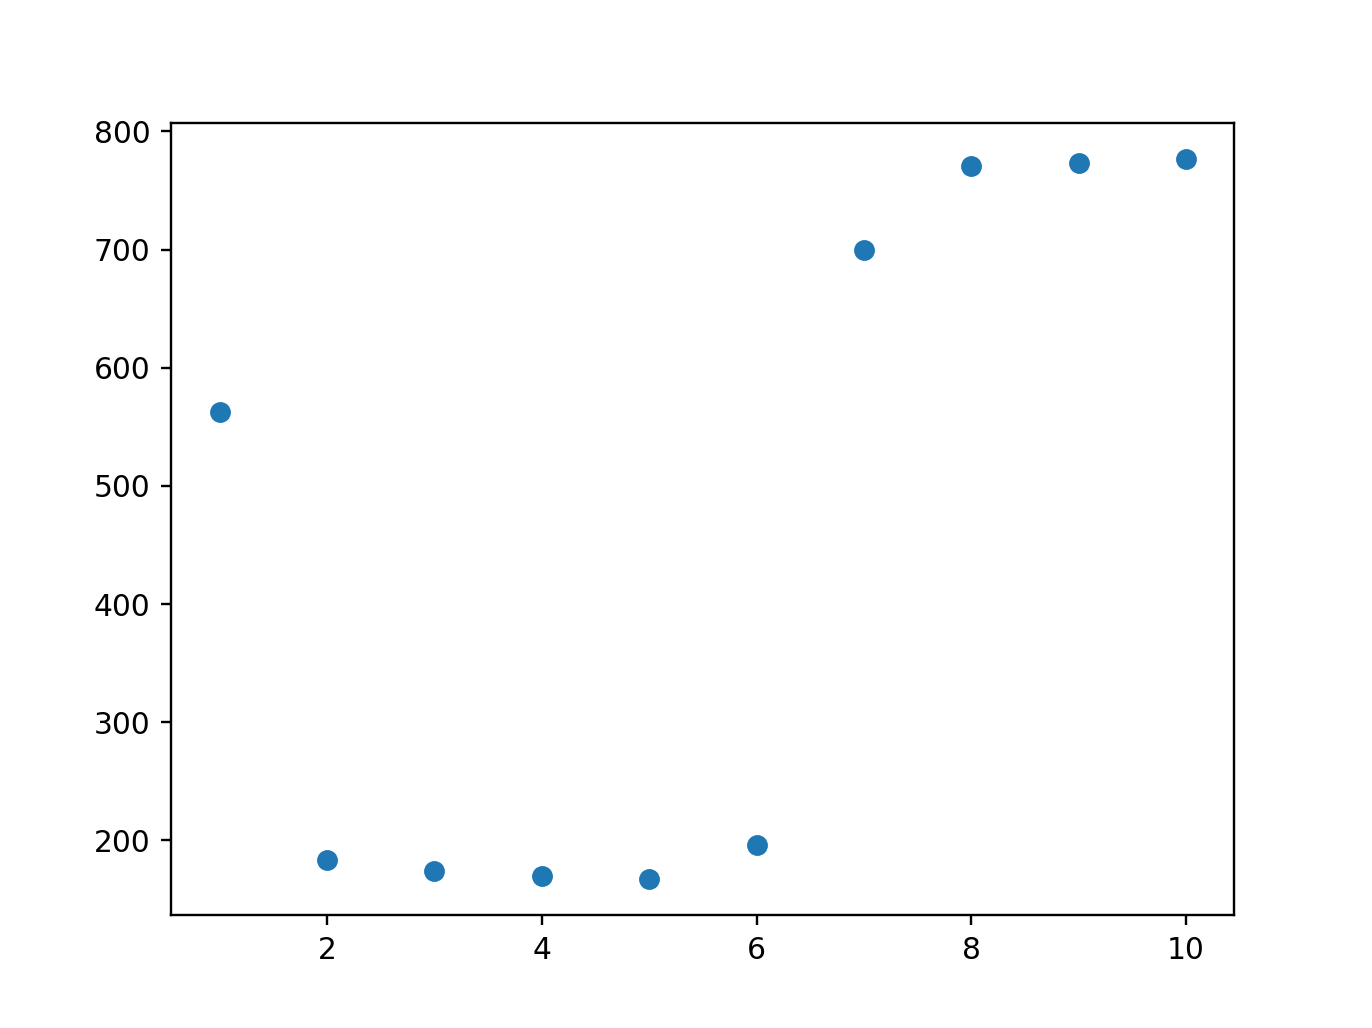

In [145]:
def model(theta, x):
    '''
    Return dependent variable values for polynomial
    
    Parameters
    ----------
    theta : tuple
        coefficients for a polynomial of degree len(theta)-1
    
    x : array-like
        values of the independent variable where f(x) should be evaluated
    '''
    
    f_x = 0
    for c_num, coeff in enumerate(theta):
        f_x += coeff*x**c_num
    
    return f_x

def aic(theta, y_obs, y_obs_unc, x_obs):
    
    res = minimize(nll, tuple(np.zeros_like(theta)), (y_obs, y_obs_unc, x_obs))

    dof = len(x_obs) - len(theta)
    
    aic = 2*res.fun + 2*len(theta) + 2*len(theta)*(len(theta) + 1)/(len(x_obs) - len(theta) - 1)
    
    return aic

aic_arr = np.zeros(10)
for deg_num, deg in enumerate(range(1,11)):
    aic_arr[deg_num] = aic(tuple(np.zeros(deg+1)), y_obs, y_obs_unc, x_obs)
    
fig, ax = plt.subplots()
ax.plot(range(1,11), aic_arr, 'o')